In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import h5py
plt.rcParams["figure.figsize"] = (11,7)

In [2]:
infile = open ("higgs_100000_pt_250_500.pkl", 'rb')
data_signal = pickle.load(infile)

signal = pd.DataFrame(data_signal)
signal.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [3]:
infile2 = open ("qcd_100000_pt_250_500.pkl", 'rb')
data_bg = pickle.load(infile2)

background = pd.DataFrame(data_bg)
background.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [4]:
hf = h5py.File('data_highLumi_pt_250_500.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

In [5]:
hf = h5py.File('data_lowLumi_pt_250_500.h5', 'r')
hf.keys()

<KeysViewHDF5 ['data']>

### 1. Make a stacked histogram plot for the feature variable: mass

In [6]:
def plot_stack_norm(key):
    plt.hist([signal[key], background[key]], bins = 300, weights = [[.001]*len(signal),[.2]*len(background)], stacked = True, histtype = 'step',color = ['orange','blue']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.title('Plot of ' + key)
    plt.show()
    
def plot_stack(key):
    plt.hist([signal[key], background[key]], 300, density = True, stacked = True, histtype = 'step',color = ['orange','blue']) 
    plt.xlabel(key)
    plt.ylabel('probability')
    plt.show()   

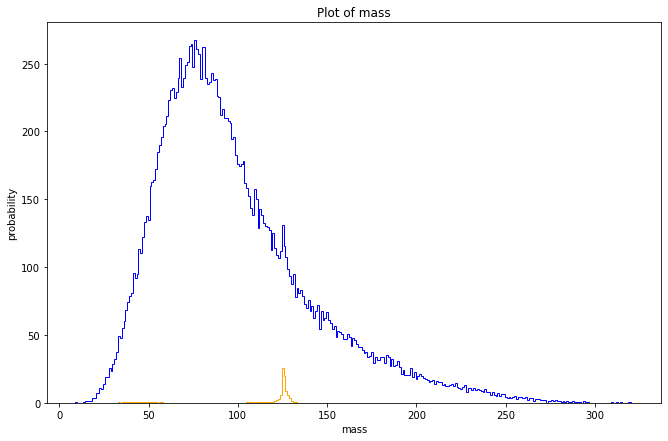

In [7]:
plot_stack_norm('mass')

#### Evaluate expected significance without any event selection. Use Poisson statistics for significance calculation. Compare the exact significance to the approximation $\frac{N_{Higgs}}{\sqrt(N_{QCD})} $. If they are equivalent, explain your findings.

From the classification of the low pt data, we have a poisson background with a mean of 20000 and an expected 100 Higgs events. We can calculate the significance of the background plus the amount of expected events. 

In [8]:
# Calculate significance
p = (1-scipy.stats.poisson.cdf(20100, 20000))
print('sigma significance of {0:1.2f}'.format(stats.norm.ppf(1-p)))

sigma significance of 0.71


In [9]:
# Approximation 
print('{0:1.2f}'.format(100/np.sqrt(20000)))

0.71


We get the same significance from the two calculations because we are looking at the sigma value for 100 away from a mean of $\lambda$ = 20000, and for a Poisson distribution the standard deviation is calculated by $\sqrt(\lambda)$

### 2. Identify mass cuts to optimize the expected significance.
Try different mass cuts systematically

Evaluate expected significance for each set of mass cuts

Identify the set of mass cuts which give you the highest significance.

In [10]:
def slicer(lower, upper, key, signal, bkgd):
    bkgd_low = bkgd[bkgd[key] < lower].index
    bkgd_high = bkgd[bkgd[key] > upper].index
    new_bg = bkgd.drop(bkgd_low)
    new_bg = new_bg.drop(bkgd_high)
    
    signal_low = signal[signal[key] < lower].index
    signal_high = signal[signal[key] > upper].index
    new_signal = signal.drop(signal_low)
    new_signal = new_signal.drop(signal_high)
    
    # normalize to find new expected values
    a = 0.2
    b = 0.001
    y_bg = int(a * len(new_bg))
    percent_bg = len(new_bg) / 100000
    y_signal = int(b * len(new_signal))
    percent_signal = len(new_signal) / 100000
    
    lam = y_bg 
    signal = y_bg + y_signal
    p = stats.poisson.sf(signal, lam)
    sigma = stats.norm.ppf(1-p)
    print('Significance of {0:1.3f} for a cut from {1:1.1f} to {2:1.1f}'.format(sigma,lower,upper))

    return(new_signal, new_bg, sigma)

In [11]:
signal_slice, bkgd_slice, sigma = slicer(0,300, 'mass', signal, background)
signal_slice, bkgd_slice, sigma = slicer(100, 150, 'mass', signal, background)
signal_slice, bkgd_slice, sigma = slicer(110, 130, 'mass', signal, background)
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background)

Significance of 0.711 for a cut from 0.0 to 300.0
Significance of 1.173 for a cut from 100.0 to 150.0
Significance of 1.695 for a cut from 110.0 to 130.0
Significance of 2.387 for a cut from 120.0 to 130.0


### 3. Make two sets of stacked histogram plots for the rest of the features
Set A without any event selection

In [12]:
def plot_stack_slice(key):
    plt.hist([signal_slice[key], bkgd_slice[key]], 300, weights = [[.001]*len(signal_slice),[.2]*len(bkgd_slice)], stacked = True, histtype = 'step',color = ['orange','blue']) 
    plt.xlabel(key)
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

In [13]:
def plot_mult(key):
        plot_stack_norm(key)
        plot_stack_slice(key)

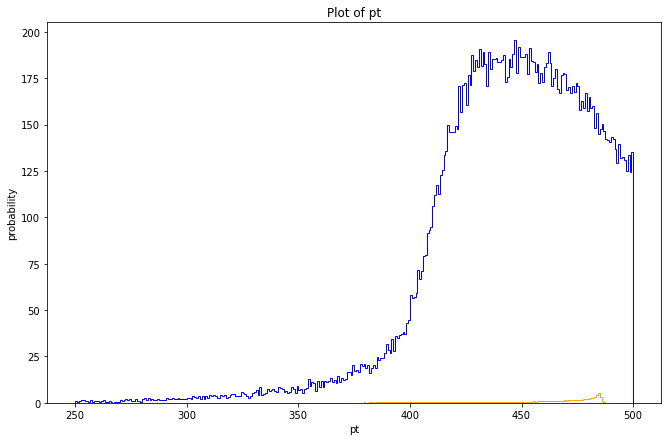

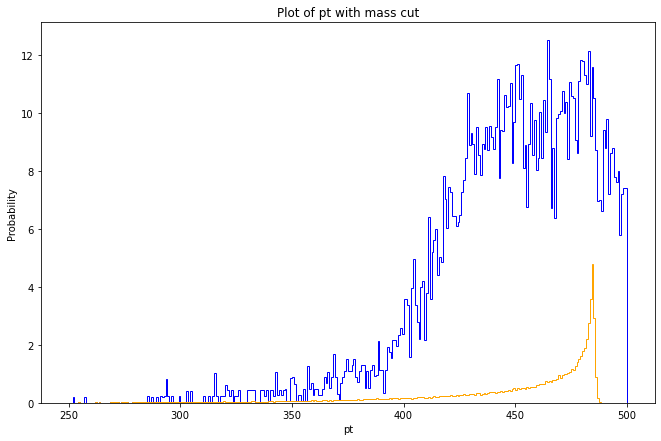

In [14]:
plot_mult('pt')

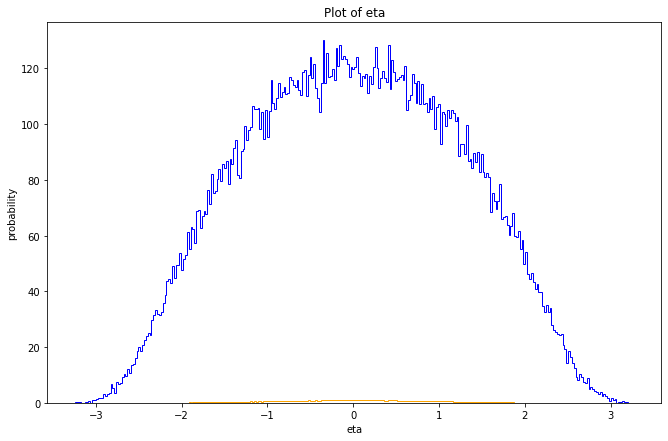

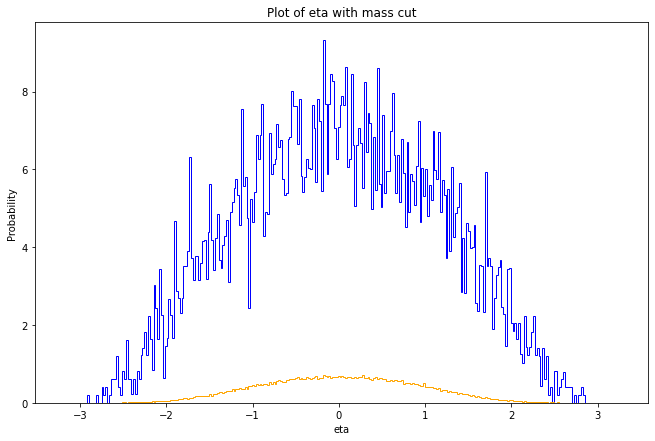

In [15]:
plot_mult('eta')

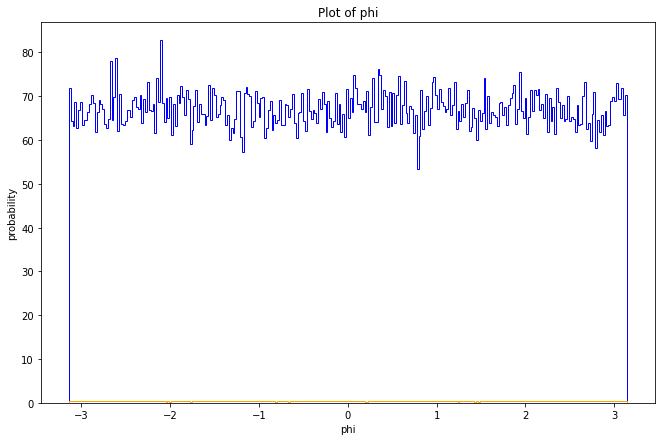

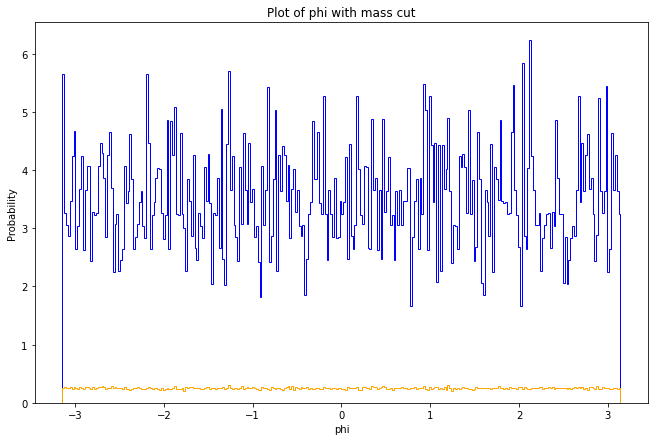

In [16]:
plot_mult('phi')

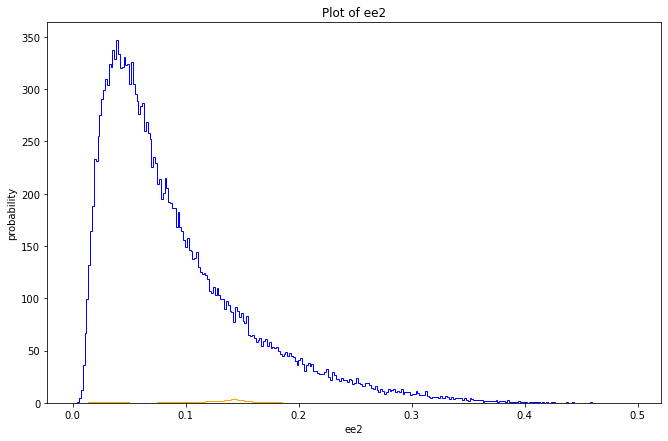

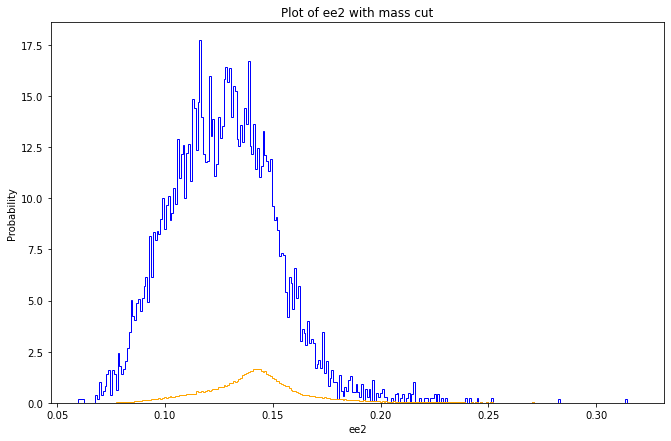

In [17]:
plot_mult('ee2')

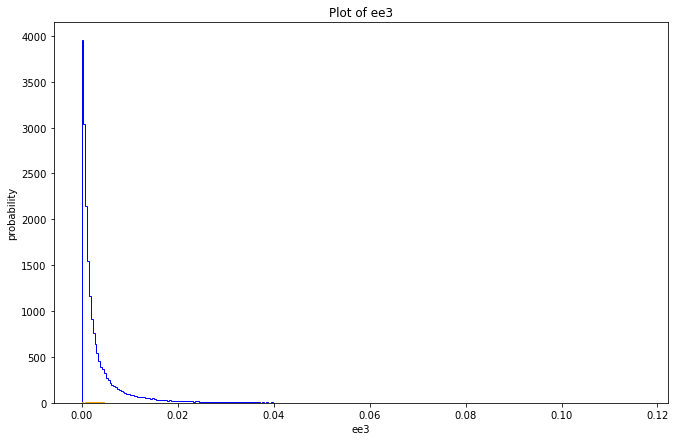

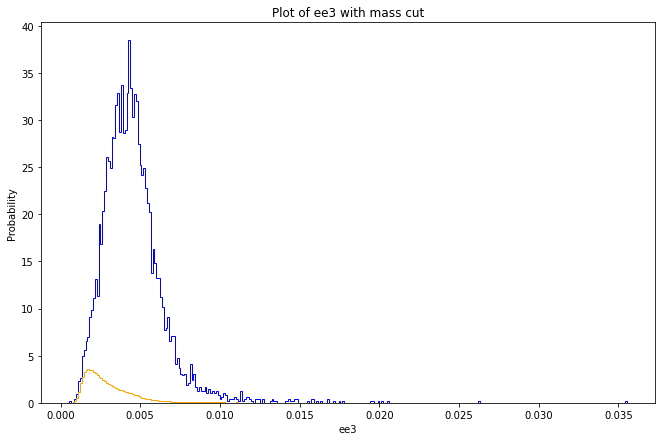

In [18]:
plot_mult('ee3')

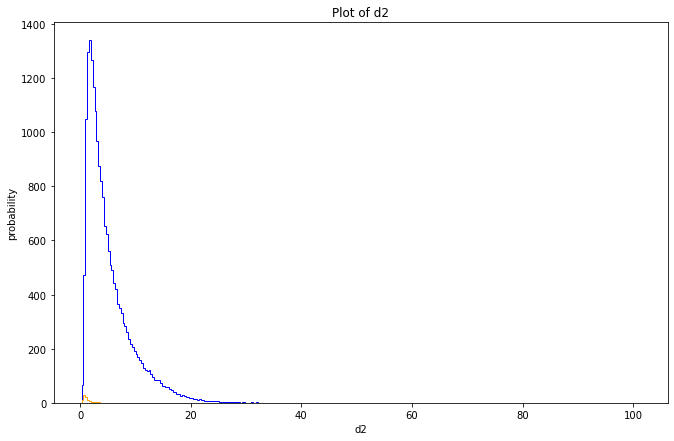

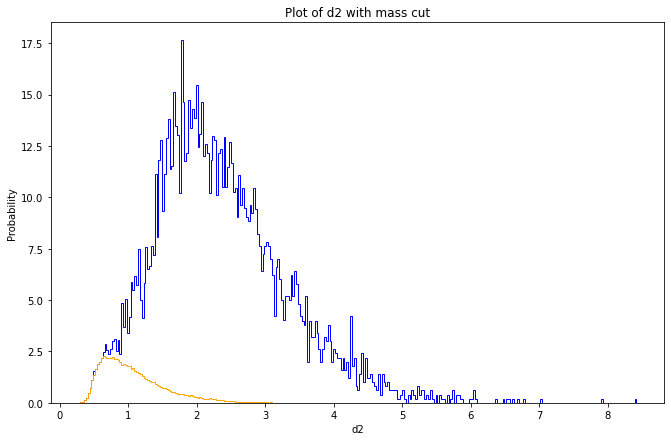

In [19]:
plot_mult('d2')

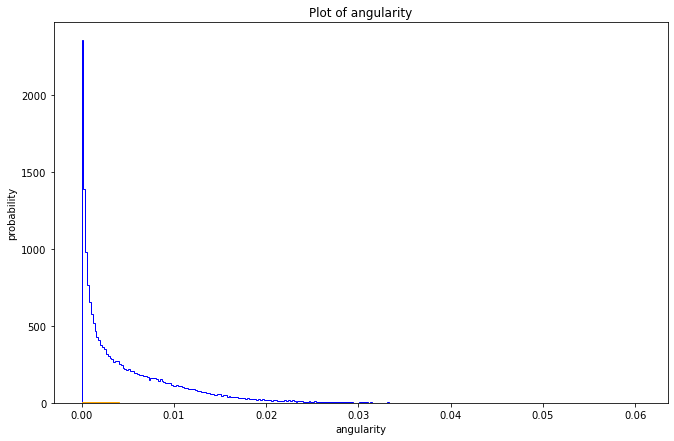

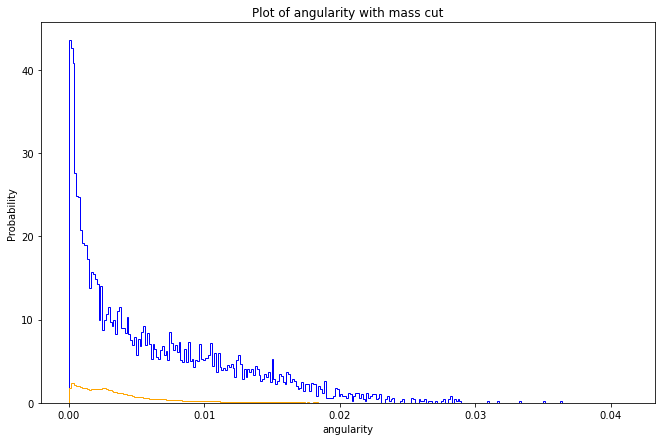

In [20]:
plot_mult('angularity')

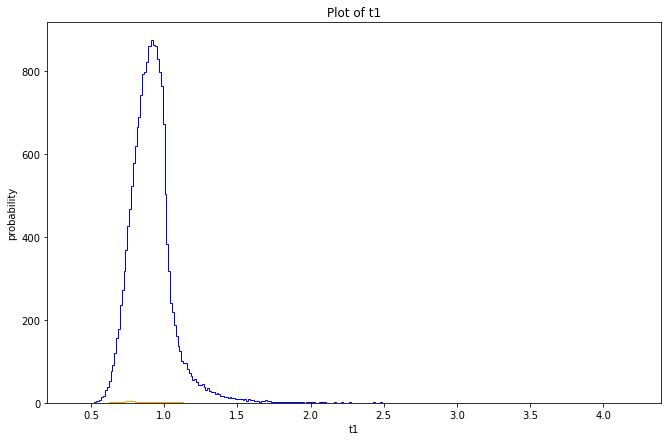

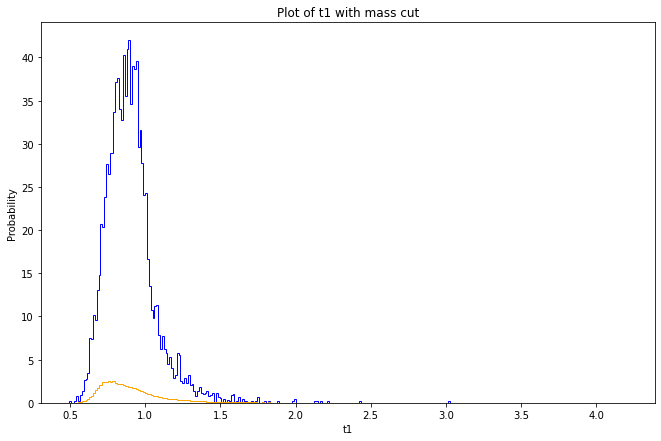

In [21]:
plot_mult('t1')

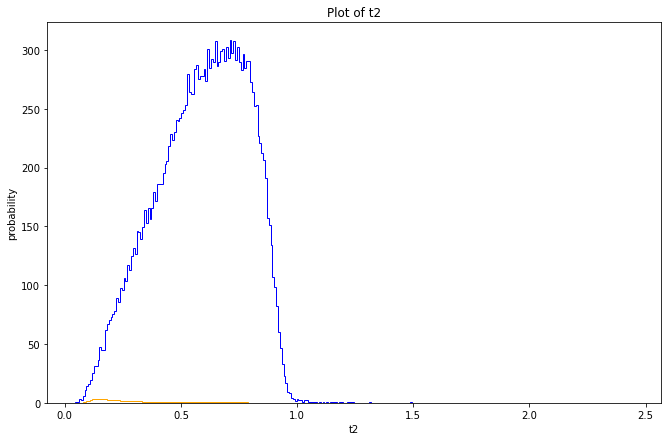

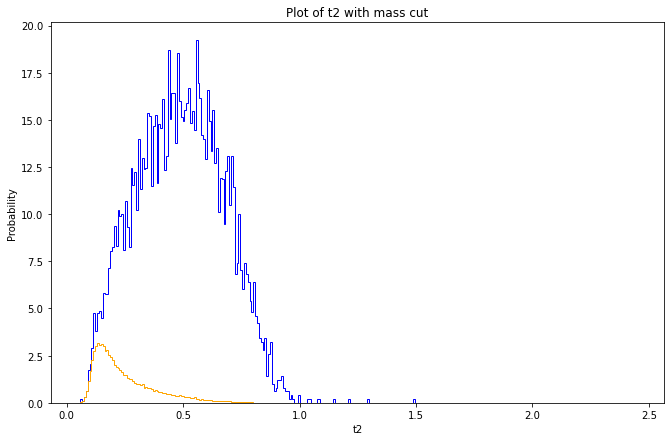

In [22]:
plot_mult('t2')

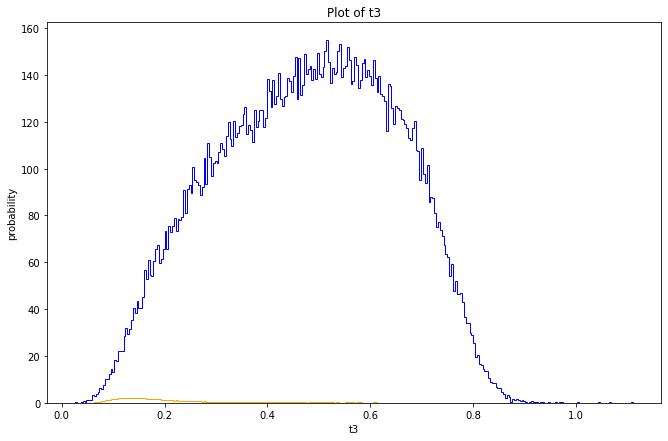

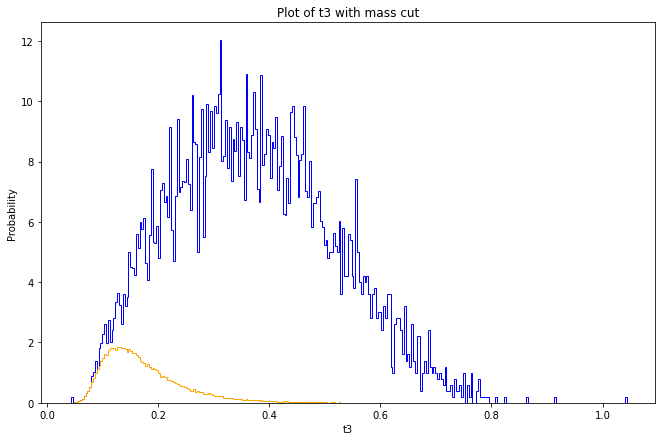

In [23]:
plot_mult('t3')

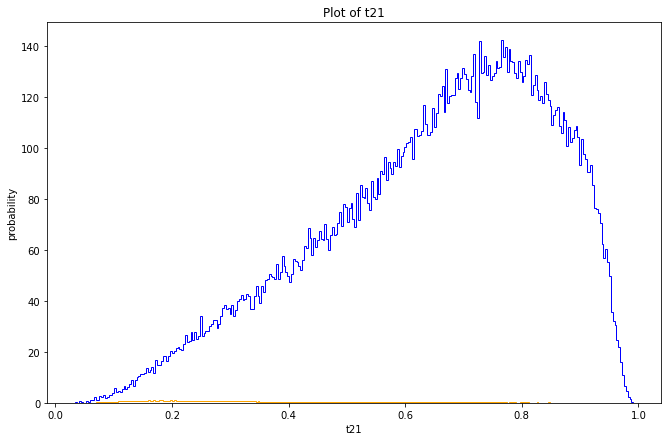

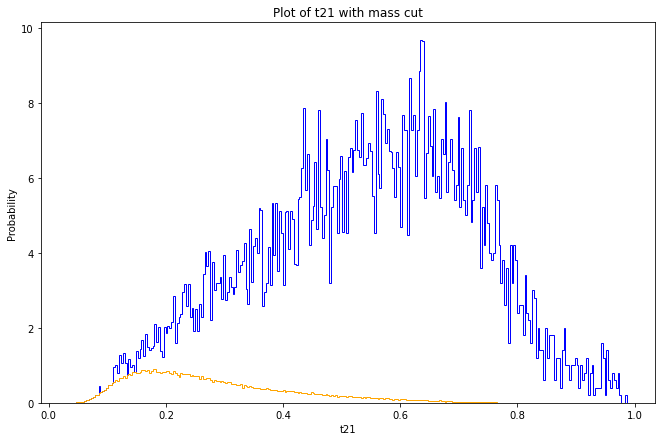

In [24]:
plot_mult('t21')

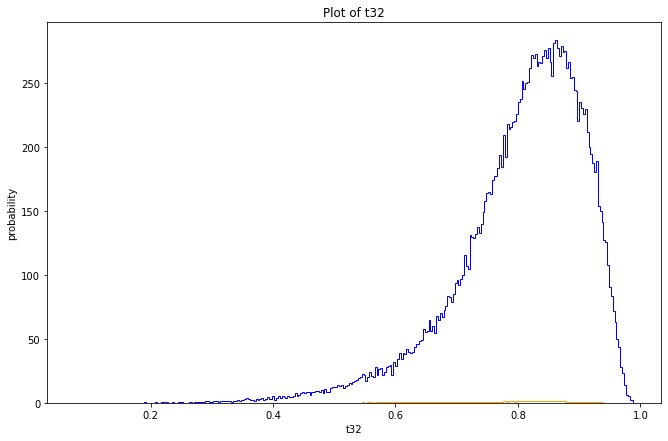

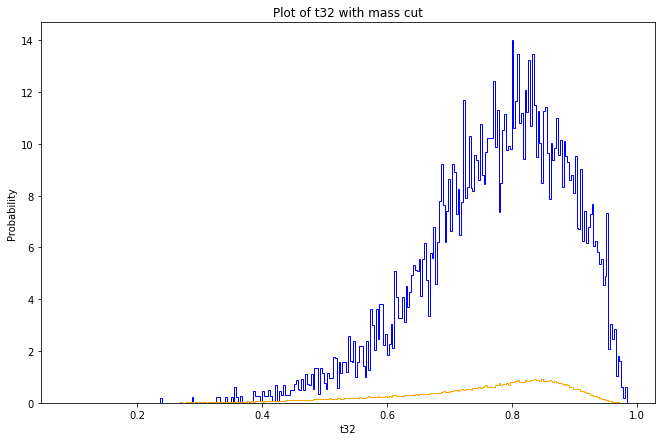

In [25]:
plot_mult('t32')

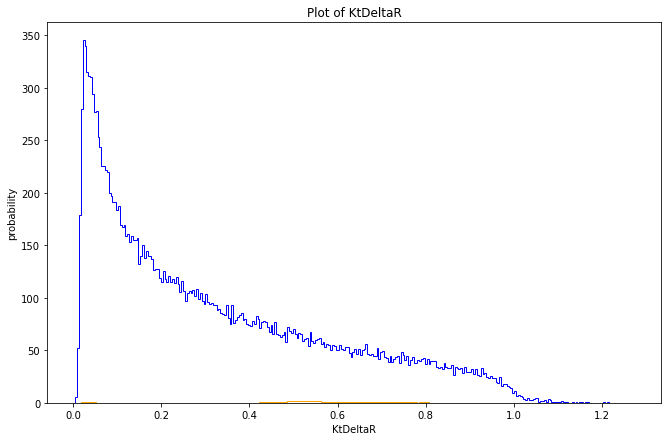

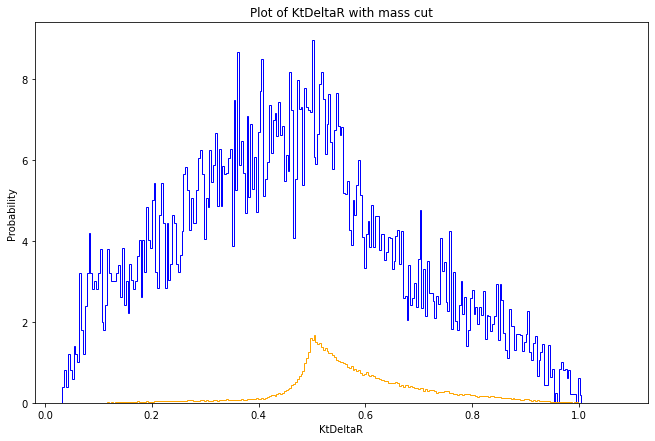

In [26]:
plot_mult('KtDeltaR')

-Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut)

-Can you identify another feature to further improve your expected signifiance?

### 4. Optimize event selections using multiple features (if necessary)
Find a set of feature cuts which achieve high expected significance.

Compare significance (before/after event selection) derived in your pT samples to your lab partner. Describe your findings.

In [27]:
#signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background)
def slice_on_d2(low_d2, high_d2):
    output_d2 = slicer(low_d2, high_d2, 'd2', signal_slice, bkgd_slice)

slice_on_d2(0, 5)
slice_on_d2(0, 3)
slice_on_d2(0, 1)
slice_on_d2(0, 1.5)
slice_on_d2(0, 1.55)

Significance of 2.404 for a cut from 0.0 to 5.0
Significance of 2.725 for a cut from 0.0 to 3.0
Significance of 8.210 for a cut from 0.0 to 1.0
Significance of 5.349 for a cut from 0.0 to 1.5
Significance of 5.110 for a cut from 0.0 to 1.6


## Lab 8

In [28]:
high_lum = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lum = pd.read_hdf('data_lowLumi_pt_250_500.h5')

print('high lum: ', high_lum.shape)
print('low lum: ', low_lum.shape)

high lum:  (40344, 14)
low lum:  (4060, 14)


### 1. High luminosity data
For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.

Evaluate observed significance and compare your results to expectation.

In [54]:
def slice_lumi(lower, upper, key, lumi):
    
    ind_lumi_below = lumi[lumi[key] < lower].index
    ind_lumi_above = lumi[lumi[key] > upper].index
    new_lumi = lumi.drop(ind_lumi_below)
    new_lumi = new_lumi.drop(ind_lumi_above)
    
    return new_lumi
   

In [49]:
def plot_stack_norm_high(key):
    bg_wt = np.full(100000,(20000/21000)* (len(high_lum)/100000))
    sig_wt = np.full(100000, (100/21000) *(len(high_lum)/100000))
    lum_wt = np.full(len(high_lum), len(high_lum)/100000)
    plt.hist([signal[key], background[key], high_lum[key]], bins = 300, weights = [sig_wt,bg_wt,lum_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD', 'High Lum'], color = ['orange', 'blue', 'green']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.title('Plot of ' + key)
    if key == 'd2':
        plt.xlim([0, 40])
    plt.legend()
    plt.show()
    


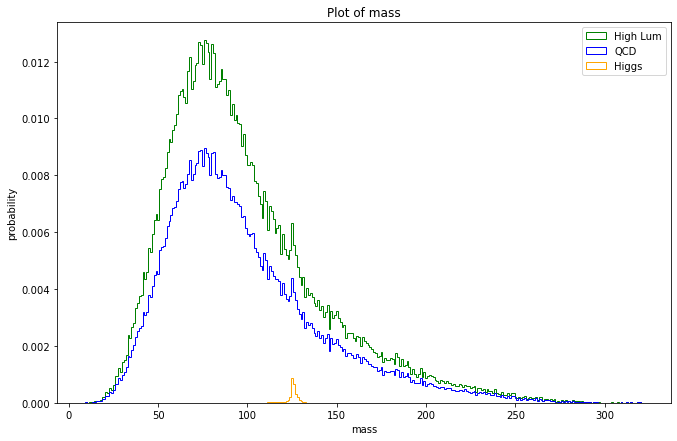

In [50]:
plot_stack_norm_high('mass')

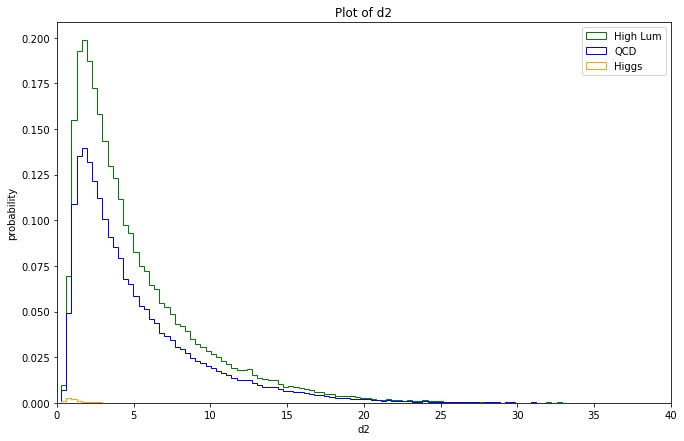

In [70]:
plot_stack_norm_high('d2')

In [71]:
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background)

Significance of 2.387 for a cut from 120.0 to 130.0


In [94]:
def plot_stack_slice_high(key):
    if key == 'mass':
        lum_slice = slice_lumi(120, 130, 'mass', high_lum)
    else:
        lum_slice = slice_lumi(0, 1.5, 'd2', high_lum)
    sig_wt = np.full(len(signal_slice),(20000/21000)* (len(lum_slice)/100000))
    bg_wt = np.full(len(bkgd_slice), (100/21000) *(len(lum_slice)/100000))
    lum_wt = np.full(len(lum_slice), len(lum_slice)/100000)
    plt.hist([signal_slice[key], bkgd_slice[key]], bins = 300, weights = [sig_wt, bg_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD'], color = ['orange', 'blue'])
    plt.hist(lum_slice[key], bins = 300, density= True, histtype = 'step', label = 'High Lum', color = 'green')
    plt.xlabel(key)
    plt.legend()
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

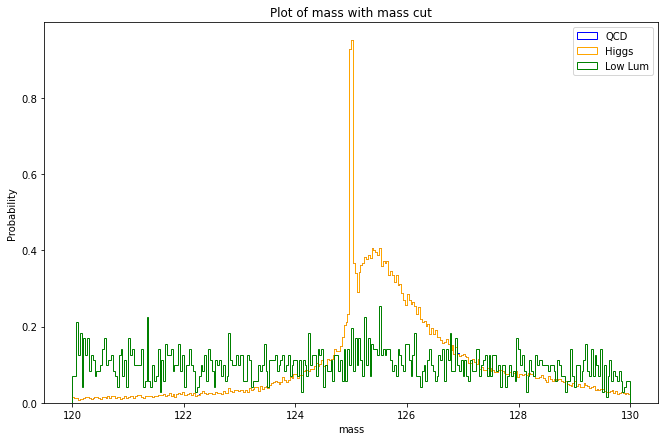

In [92]:
plot_stack_slice_high('mass')

In [107]:
signal_slice, bkgd_slice, sigma = slicer(0, 1.5, 'd2', signal, background)

Significance of 1.395 for a cut from 0.0 to 1.5


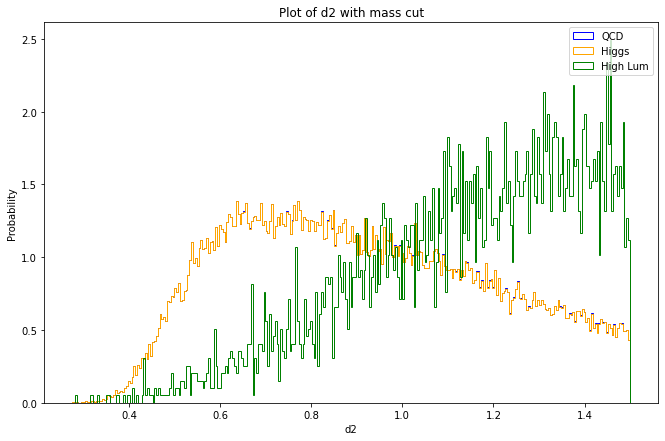

In [108]:
plot_stack_slice_high('d2')

In [ ]:
# Calculate the parameter lambda of the background
qcd_sliced, higgs_sliced, highLumi_sliced = slice_data(qcd_dict, higgs_dict, highLumi, 'mass', 120, 130)
qcd_sliced, higgs_sliced, highLumi_sliced = slice_data(qcd_sliced, higgs_sliced, highLumi_sliced, 'd2', 0, 1.4)
lam = int(len(qcd_sliced) * 0.2) # ratio given in Lab 7
print(f'After event selection there are {lam} expected QCD background events.')

# Observation is the length of lumi array after event selection
signal_highLumi = len(highLumi_sliced)
print(f'The observation is {signal_highLumi} events.')

# Calculate significance of this observation
sigma_highLumi = calc_sigma_poisson(lam, signal_highLumi)
print(f'The significance of my observation of low luminosity events after event sel

### 2. Low luminosity data
Do as before with the high luminosity data and comment on the difference.

In [84]:
def plot_stack_norm_low(key):
    plt.hist([signal[key], background[key], low_lum[key]], bins = 300, weights = [[.001]*len(signal),[.2]*len(background), [.4]*len(low_lum)], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD', 'Low Lum'], color = ['orange', 'blue', 'green']) 
    plt.xlabel(key)
    plt.ylabel("probability")
    plt.title('Plot of ' + key)
    if key == 'd2':
        plt.xlim([0, 40])
    plt.legend()
    plt.show()

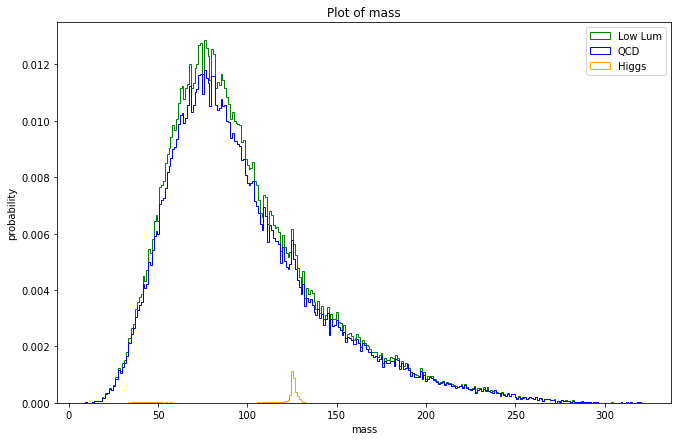

In [85]:
plot_stack_norm_low('mass')

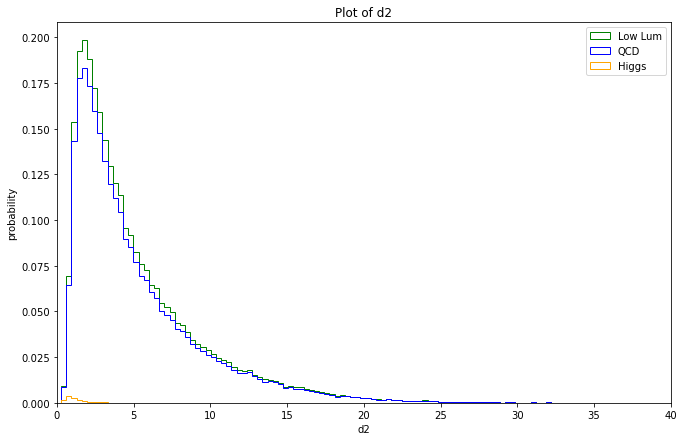

In [86]:
plot_stack_norm_low('d2')

In [80]:
def plot_stack_slice_low(key):
    if key == 'mass':
        lum_slice = slice_lumi(120, 130, 'mass', high_lum)
    else:
        lum_slice = slice_lumi(0, 1.5, 'd2', high_lum)
    sig_wt = np.full(len(signal_slice),(20000/21000)* (len(lum_slice)/100000))
    bg_wt = np.full(len(bkgd_slice), (100/21000) *(len(lum_slice)/100000))
    lum_wt = np.full(len(lum_slice), len(lum_slice)/100000)
    plt.hist([signal_slice[key], bkgd_slice[key]], bins = 300, weights = [sig_wt, bg_wt], 
             density = True, stacked = True, histtype = 'step', label = ['Higgs', 'QCD'], color = ['orange', 'blue'])
    plt.hist(lum_slice[key], bins = 300, density= True, histtype = 'step', label = 'High Lum', color = 'green')
    plt.xlabel(key)
    plt.legend()
    plt.ylabel('Probability')
    plt.title('Plot of ' + key + ' with mass cut')
    plt.show()

In [109]:
signal_slice, bkgd_slice, sigma = slicer(120, 130, 'mass', signal, background)

Significance of 2.387 for a cut from 120.0 to 130.0


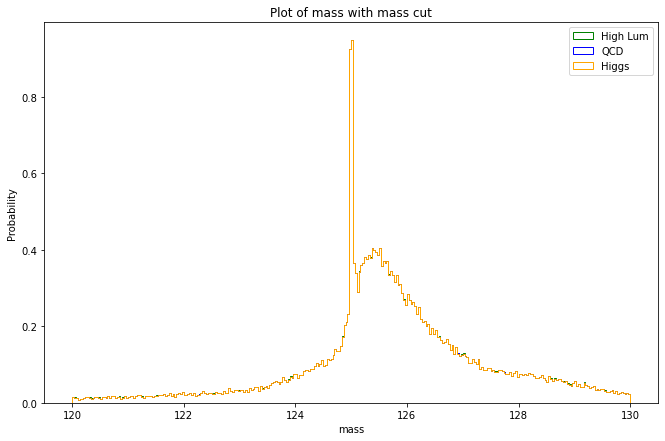

In [110]:
plot_stack_slice_low('mass')

In [111]:
signal_slice, bkgd_slice, sigma = slicer(0, 1.5, 'd2', signal, background)

Significance of 1.395 for a cut from 0.0 to 1.5


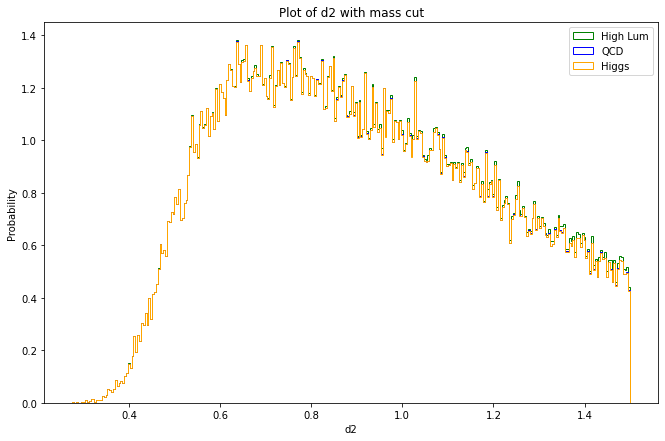

In [112]:
plot_stack_slice_low('d2')

### 3. 95% Confidence Level of signal yields

In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield.

Evaluate the expected 95% confidence level upper limit

Evaluate the observed 95% confidence level upper limit

Compare expectation to observation. Comment on your finding.